In [141]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/h2o-best-submission-till-now/submission_auto_arima_univ_after_outlier_handling.csv
/kaggle/input/h2o-olympics-new-outlier-handling-scaling-std/new_train_after_outlier_removal_standardized.csv
/kaggle/input/h2o-olympics-new-outlier-handling-scaling-std/new_train_after_outlier_removal_scaled.csv
/kaggle/input/h2o-olympics-new-outlier-handling-scaling-std/new_test_after_outlier_removal_standardized.csv
/kaggle/input/h2o-olympics-new-outlier-handling-scaling-std/new_test_after_outlier_removal.csv
/kaggle/input/h2o-olympics-new-outlier-handling-scaling-std/new_test_after_outlier_removal_scaled.csv
/kaggle/input/h2o-olympics-new-outlier-handling-scaling-std/new_train_after_outlier_removal.csv
/kaggle/input/h2o-olympics-h2o-world-india/AQI_Hackathon/sample_submission.csv
/kaggle/input/h2o-olympics-h2o-world-india/AQI_Hackathon/train.csv


In [142]:
import h2o
from h2o.automl import H2OAutoML

# Start the H2O cluster (locally)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 hours 55 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.2
H2O_cluster_version_age:,1 month and 7 days
H2O_cluster_name:,H2O_from_python_unknownUser_8x1k0i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.410 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [143]:
train_df = pd.read_csv('/kaggle/input/h2o-olympics-new-outlier-handling-scaling-std/new_train_after_outlier_removal.csv', parse_dates=["Date"])
display(train_df.head().style.set_caption('Train data'))

test_df = pd.read_csv('/kaggle/input/h2o-olympics-new-outlier-handling-scaling-std/new_test_after_outlier_removal.csv', parse_dates=["Date"])
display(test_df.head().style.set_caption('Test data'))

,StateCode,Date,PM2.5,PM10,O3,CO,SO2,AQI,DayOfWeek,DayOfMonth,WeekOfYear,Month,DayOfYear,ID
0,AS,2021-08-17 00:00:00,51.836400,120.370200,18.023400,0.489600,14.310600,94.000000,1,17,33,8,229,0
1,AS,2021-08-18 00:00:00,59.476200,87.097800,34.527000,0.479400,14.759400,124.000000,2,18,33,8,230,0
2,AS,2021-08-19 00:00:00,61.077600,79.600800,42.054600,0.520200,16.748400,82.000000,3,19,33,8,231,0
3,AS,2021-08-20 00:00:00,56.722200,94.207200,45.787800,0.499800,23.342738,107.000000,4,20,33,8,232,0
4,AS,2021-08-21 00:00:00,85.333200,136.782000,44.563800,1.111800,23.342738,107.000000,5,21,33,8,233,0


,StateCode,Date,PM2.5,PM10,O3,CO,SO2,DayOfWeek,DayOfMonth,WeekOfYear,Month,DayOfYear,ID,ID_Date
0,AS,2022-12-04 00:00:00,18.874280,32.257500,42.990609,0.439418,16.214026,6,4,48,12,338,0,AS_4_2022-12-04
1,AS,2022-12-05 00:00:00,19.847572,35.182928,40.845752,0.457979,16.144028,0,5,49,12,339,0,AS_4_2022-12-05
2,AS,2022-12-06 00:00:00,20.355641,35.182928,39.721339,0.465124,16.100848,1,6,49,12,340,0,AS_4_2022-12-06
3,AS,2022-12-07 00:00:00,20.355641,35.182928,39.131881,0.465124,16.074212,2,7,49,12,341,0,AS_4_2022-12-07
4,AS,2022-12-08 00:00:00,20.355641,35.182928,38.822865,0.465124,16.057782,3,8,49,12,342,0,AS_4_2022-12-08


In [144]:
submission_df = pd.read_csv('/kaggle/input/h2o-olympics-h2o-world-india/AQI_Hackathon/sample_submission.csv')

In [145]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

train_df["PM2.5_SubIndex"] = train_df["PM2.5"].apply(lambda x: get_PM25_subindex(x))

In [146]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

train_df["PM10_SubIndex"] = train_df["PM10"].apply(lambda x: get_PM10_subindex(x))

In [147]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

train_df["SO2_SubIndex"] = train_df["SO2"].apply(lambda x: get_SO2_subindex(x))

In [148]:
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

train_df["CO_SubIndex"] = train_df["CO"].apply(lambda x: get_CO_subindex(x))

In [149]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

train_df["O3_SubIndex"] = train_df["O3"].apply(lambda x: get_O3_subindex(x))

In [150]:
train_df

,StateCode,Date,PM2.5,PM10,O3,CO,SO2,AQI,DayOfWeek,DayOfMonth,WeekOfYear,Month,DayOfYear,ID,PM2.5_SubIndex,PM10_SubIndex,SO2_SubIndex,CO_SubIndex,O3_SubIndex
0,AS,2021-08-17,51.8364,120.3702,18.0234,0.48960,14.310600,94.0,1,17,33,8,229,0,86.3940,113.580133,17.888250,24.4800,18.0234
1,AS,2021-08-18,59.4762,87.0978,34.5270,0.47940,14.759400,124.0,2,18,33,8,230,0,99.1270,87.097800,18.449250,23.9700,34.5270
2,AS,2021-08-19,61.0776,79.6008,42.0546,0.52020,16.748400,82.0,3,19,33,8,231,0,103.5920,79.600800,20.935500,26.0100,42.0546
3,AS,2021-08-20,56.7222,94.2072,45.7878,0.49980,23.342738,107.0,4,20,33,8,232,0,94.5370,94.207200,29.178422,24.9900,45.7878
4,AS,2021-08-21,85.3332,136.7820,44.5638,1.11180,23.342738,107.0,5,21,33,8,233,0,184.4440,124.521333,29.178422,55.5900,44.5638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25818,WB,2022-11-29,16.3275,33.8940,36.5190,0.65100,3.549000,47.0,1,29,48,11,333,39,27.2125,33.894000,4.436250,32.5500,36.5190
25819,WB,2022-11-30,15.2880,29.9145,37.2225,0.63525,2.940000,52.0,2,30,48,11,334,39,25.4800,29.914500,3.675000,31.7625,37.2225
25820,WB,2022-12-01,14.1015,31.1325,27.1845,0.67200,5.428500,41.0,3,1,48,12,335,39,23.5025,31.132500,6.785625,33.6000,27.1845
25821,WB,2022-12-02,17.8605,30.5340,30.0510,0.59850,7.423500,40.0,4,2,48,12,336,39,29.7675,30.534000,9.279375,29.9250,30.0510


In [151]:
df = train_df

In [152]:
# AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

df["Checks"] = (df["PM2.5_SubIndex"] > 0).astype(int) + \
                (df["PM10_SubIndex"] > 0).astype(int) + \
                (df["SO2_SubIndex"] > 0).astype(int) + \
                (df["CO_SubIndex"] > 0).astype(int) + \
                (df["O3_SubIndex"] > 0).astype(int)

df["AQI_subindex_calculated"] = round(df[["PM2.5_SubIndex", "PM10_SubIndex", "SO2_SubIndex", 
                                 "CO_SubIndex", "O3_SubIndex"]].max(axis = 1))
df.loc[df["PM2.5_SubIndex"] + df["PM10_SubIndex"] <= 0, "AQI_subindex_calculated"] = np.NaN
df.loc[df.Checks < 3, "AQI_subindex_calculated"] = np.NaN

df["AQI_bucket_calculated"] = df["AQI_subindex_calculated"].apply(lambda x: get_AQI_bucket(x))
df[~df.AQI_subindex_calculated.isna()].head(13)

,StateCode,Date,PM2.5,PM10,O3,CO,SO2,AQI,DayOfWeek,DayOfMonth,...,DayOfYear,ID,PM2.5_SubIndex,PM10_SubIndex,SO2_SubIndex,CO_SubIndex,O3_SubIndex,Checks,AQI_subindex_calculated,AQI_bucket_calculated
0,AS,2021-08-17,51.836400,120.370200,18.023400,0.489600,14.310600,94.000000,1,17,...,229,0,86.394000,113.580133,17.888250,24.480000,18.023400,5,114.0,Moderate
1,AS,2021-08-18,59.476200,87.097800,34.527000,0.479400,14.759400,124.000000,2,18,...,230,0,99.127000,87.097800,18.449250,23.970000,34.527000,5,99.0,Satisfactory
2,AS,2021-08-19,61.077600,79.600800,42.054600,0.520200,16.748400,82.000000,3,19,...,231,0,103.592000,79.600800,20.935500,26.010000,42.054600,5,104.0,Moderate
3,AS,2021-08-20,56.722200,94.207200,45.787800,0.499800,23.342738,107.000000,4,20,...,232,0,94.537000,94.207200,29.178422,24.990000,45.787800,5,95.0,Satisfactory
4,AS,2021-08-21,85.333200,136.782000,44.563800,1.111800,23.342738,107.000000,5,21,...,233,0,184.444000,124.521333,29.178422,55.590000,44.563800,5,184.0,Moderate
5,AS,2021-08-22,144.636000,248.788200,32.844000,1.550400,23.342738,299.000000,6,22,...,234,0,318.950769,199.192133,29.178422,77.520000,32.844000,5,319.0,Very Poor
6,AS,2021-08-23,135.925200,224.349000,36.934200,1.152600,23.342738,327.000000,0,23,...,235,0,312.250154,182.899333,29.178422,57.630000,36.934200,5,312.0,Very Poor
7,AS,2021-08-24,71.298000,117.187800,22.011600,0.550800,19.339200,210.000000,1,24,...,236,0,137.660000,111.458533,24.174000,27.540000,22.011600,5,138.0,Moderate
8,AS,2021-08-25,132.477600,239.516400,20.553000,1.708500,19.400400,210.000000,2,25,...,237,0,309.598154,193.010933,24.250500,85.425000,20.553000,5,310.0,Very Poor
9,AS,2021-08-26,96.175800,176.500800,17.319600,1.132200,17.044200,291.000000,3,26,...,238,0,220.586000,151.000533,21.305250,56.610000,17.319600,5,221.0,Poor


In [153]:
# # AQI bucketing
# def get_AQI_bucket(x):
#     if x <= 50:
#         return "Good"
#     elif x <= 100:
#         return "Satisfactory"
#     elif x <= 200:
#         return "Moderate"
#     elif x <= 300:
#         return "Poor"
#     elif x <= 400:
#         return "Very Poor"
#     elif x > 400:
#         return "Severe"
#     else:
#         return np.NaN

df["Checks"] = (df["PM2.5"] > 0).astype(int) + \
                (df["PM10"] > 0).astype(int) + \
                (df["SO2"] > 0).astype(int) + \
                (df["CO"] > 0).astype(int) + \
                (df["O3"] > 0).astype(int)

df["AQI_calculated"] = round(df[["PM2.5", "PM10", "SO2", 
                                 "CO", "O3"]].max(axis = 1))
df.loc[df["PM2.5"] + df["PM10"] <= 0, "AQI_calculated"] = np.NaN
df.loc[df.Checks < 3, "AQI_calculated"] = np.NaN

# df["AQI_bucket_calculated"] = df["AQI_subindex_calculated"].apply(lambda x: get_AQI_bucket(x))
df[~df.AQI_calculated.isna()].head(13)

,StateCode,Date,PM2.5,PM10,O3,CO,SO2,AQI,DayOfWeek,DayOfMonth,...,ID,PM2.5_SubIndex,PM10_SubIndex,SO2_SubIndex,CO_SubIndex,O3_SubIndex,Checks,AQI_subindex_calculated,AQI_bucket_calculated,AQI_calculated
0,AS,2021-08-17,51.836400,120.370200,18.023400,0.489600,14.310600,94.000000,1,17,...,0,86.394000,113.580133,17.888250,24.480000,18.023400,5,114.0,Moderate,120.0
1,AS,2021-08-18,59.476200,87.097800,34.527000,0.479400,14.759400,124.000000,2,18,...,0,99.127000,87.097800,18.449250,23.970000,34.527000,5,99.0,Satisfactory,87.0
2,AS,2021-08-19,61.077600,79.600800,42.054600,0.520200,16.748400,82.000000,3,19,...,0,103.592000,79.600800,20.935500,26.010000,42.054600,5,104.0,Moderate,80.0
3,AS,2021-08-20,56.722200,94.207200,45.787800,0.499800,23.342738,107.000000,4,20,...,0,94.537000,94.207200,29.178422,24.990000,45.787800,5,95.0,Satisfactory,94.0
4,AS,2021-08-21,85.333200,136.782000,44.563800,1.111800,23.342738,107.000000,5,21,...,0,184.444000,124.521333,29.178422,55.590000,44.563800,5,184.0,Moderate,137.0
5,AS,2021-08-22,144.636000,248.788200,32.844000,1.550400,23.342738,299.000000,6,22,...,0,318.950769,199.192133,29.178422,77.520000,32.844000,5,319.0,Very Poor,249.0
6,AS,2021-08-23,135.925200,224.349000,36.934200,1.152600,23.342738,327.000000,0,23,...,0,312.250154,182.899333,29.178422,57.630000,36.934200,5,312.0,Very Poor,224.0
7,AS,2021-08-24,71.298000,117.187800,22.011600,0.550800,19.339200,210.000000,1,24,...,0,137.660000,111.458533,24.174000,27.540000,22.011600,5,138.0,Moderate,117.0
8,AS,2021-08-25,132.477600,239.516400,20.553000,1.708500,19.400400,210.000000,2,25,...,0,309.598154,193.010933,24.250500,85.425000,20.553000,5,310.0,Very Poor,240.0
9,AS,2021-08-26,96.175800,176.500800,17.319600,1.132200,17.044200,291.000000,3,26,...,0,220.586000,151.000533,21.305250,56.610000,17.319600,5,221.0,Poor,177.0


In [154]:
df[~df.AQI_calculated.isna()].AQI_bucket_calculated.value_counts()

Moderate        7580
Satisfactory    6265
Very Poor       4291
Poor            3316
Good            2749
Severe          1622
Name: AQI_bucket_calculated, dtype: int64

In [155]:
df[['AQI','AQI_calculated','AQI_subindex_calculated']]

,AQI,AQI_calculated,AQI_subindex_calculated
0,94.0,120.0,114.0
1,124.0,87.0,99.0
2,82.0,80.0,104.0
3,107.0,94.0,95.0
4,107.0,137.0,184.0
...,...,...,...
25818,47.0,37.0,37.0
25819,52.0,37.0,37.0
25820,41.0,31.0,34.0
25821,40.0,31.0,31.0


In [156]:
from sklearn.model_selection import train_test_split
reg_df = df[['AQI','AQI_calculated','AQI_subindex_calculated']]
X = df[['AQI_calculated','AQI_subindex_calculated']]
y = df[['AQI']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [157]:
X_train.shape

(20658, 2)

In [158]:
y_test.shape

(5165, 1)

# Linear Regression on just AQI Columns

In [159]:
from sklearn.linear_model import LinearRegression

# create a linear regression object
reg = LinearRegression()

# fit the model to the training data
reg.fit(X_train, y_train)

# make predictions on the test data
y_pred = reg.predict(X_test)

In [160]:
y_pred.shape

(5165, 1)

In [161]:
y_test.shape

(5165, 1)

In [162]:
from sklearn.metrics import mean_absolute_error as mae
print('mean_absolute_error =',mae(y_test, y_pred))

mean_absolute_error = 22.334276126453634


In [163]:
df

,StateCode,Date,PM2.5,PM10,O3,CO,SO2,AQI,DayOfWeek,DayOfMonth,...,ID,PM2.5_SubIndex,PM10_SubIndex,SO2_SubIndex,CO_SubIndex,O3_SubIndex,Checks,AQI_subindex_calculated,AQI_bucket_calculated,AQI_calculated
0,AS,2021-08-17,51.8364,120.3702,18.0234,0.48960,14.310600,94.0,1,17,...,0,86.3940,113.580133,17.888250,24.4800,18.0234,5,114.0,Moderate,120.0
1,AS,2021-08-18,59.4762,87.0978,34.5270,0.47940,14.759400,124.0,2,18,...,0,99.1270,87.097800,18.449250,23.9700,34.5270,5,99.0,Satisfactory,87.0
2,AS,2021-08-19,61.0776,79.6008,42.0546,0.52020,16.748400,82.0,3,19,...,0,103.5920,79.600800,20.935500,26.0100,42.0546,5,104.0,Moderate,80.0
3,AS,2021-08-20,56.7222,94.2072,45.7878,0.49980,23.342738,107.0,4,20,...,0,94.5370,94.207200,29.178422,24.9900,45.7878,5,95.0,Satisfactory,94.0
4,AS,2021-08-21,85.3332,136.7820,44.5638,1.11180,23.342738,107.0,5,21,...,0,184.4440,124.521333,29.178422,55.5900,44.5638,5,184.0,Moderate,137.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25818,WB,2022-11-29,16.3275,33.8940,36.5190,0.65100,3.549000,47.0,1,29,...,39,27.2125,33.894000,4.436250,32.5500,36.5190,5,37.0,Good,37.0
25819,WB,2022-11-30,15.2880,29.9145,37.2225,0.63525,2.940000,52.0,2,30,...,39,25.4800,29.914500,3.675000,31.7625,37.2225,5,37.0,Good,37.0
25820,WB,2022-12-01,14.1015,31.1325,27.1845,0.67200,5.428500,41.0,3,1,...,39,23.5025,31.132500,6.785625,33.6000,27.1845,5,34.0,Good,31.0
25821,WB,2022-12-02,17.8605,30.5340,30.0510,0.59850,7.423500,40.0,4,2,...,39,29.7675,30.534000,9.279375,29.9250,30.0510,5,31.0,Good,31.0


In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25823 entries, 0 to 25822
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   StateCode                25823 non-null  object        
 1   Date                     25823 non-null  datetime64[ns]
 2   PM2.5                    25823 non-null  float64       
 3   PM10                     25823 non-null  float64       
 4   O3                       25823 non-null  float64       
 5   CO                       25823 non-null  float64       
 6   SO2                      25823 non-null  float64       
 7   AQI                      25823 non-null  float64       
 8   DayOfWeek                25823 non-null  int64         
 9   DayOfMonth               25823 non-null  int64         
 10  WeekOfYear               25823 non-null  int64         
 11  Month                    25823 non-null  int64         
 12  DayOfYear                25823 n

In [166]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25823 entries, 0 to 25822
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   StateCode                25823 non-null  object        
 1   Date                     25823 non-null  datetime64[ns]
 2   PM2.5                    25823 non-null  float64       
 3   PM10                     25823 non-null  float64       
 4   O3                       25823 non-null  float64       
 5   CO                       25823 non-null  float64       
 6   SO2                      25823 non-null  float64       
 7   AQI                      25823 non-null  float64       
 8   DayOfWeek                25823 non-null  int64         
 9   DayOfMonth               25823 non-null  int64         
 10  WeekOfYear               25823 non-null  int64         
 11  Month                    25823 non-null  int64         
 12  DayOfYear                25823 n

In [167]:
# df.to_csv('new_train_df_after_aqi_calc.csv',index=False)

# Testing on just AQI, AQI_subindex_calculated and AQI_calculated

In [114]:
# convert pandas dataframe to h2o dataframe
reg_df_h2o = h2o.H2OFrame(reg_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [115]:
# identify predictors and response variable
x = reg_df_h2o.columns[1:]
y = 'AQI'

# split data into training and test sets
train, test = reg_df_h2o.split_frame(ratios=[0.8], seed=42)

# initialize AutoML and start training

aml = H2OAutoML(seed=42, sort_metric='MAE', verbosity='info', max_runtime_secs=600, nfolds=0)
aml.train(x=x, y=y, training_frame=train, validation_frame=test)

# view the leaderboard of models
lb = aml.leaderboard
print(lb.head(rows=lb.nrows))

# make predictions on the test data using the best model
y_pred = aml.leader.predict(test)

# evaluate the model's performance
perf = aml.leader.model_performance(test)
perf

AutoML progress: |
09:35:00.613: Project: AutoML_2_20230417_93500
09:35:00.613: Cross-validation disabled by user: no fold column nor nfolds > 1.
09:35:00.613: Setting stopping tolerance adaptively based on the training frame: 0.0069409306843357865
09:35:00.613: Build control seed: 42
09:35:00.613: training frame: Frame key: AutoML_2_20230417_93500_training_py_5_sid_bd45    cols: 3    rows: 20757  chunks: 1    size: 249288  checksum: 2338858650314312426
09:35:00.614: validation frame: Frame key: py_6_sid_bd45    cols: 3    rows: 5066  chunks: 1    size: 60996  checksum: -2194735685248054283
09:35:00.614: leaderboard frame: Frame key: py_6_sid_bd45    cols: 3    rows: 5066  chunks: 1    size: 60996  checksum: -2194735685248054283
09:35:00.614: blending frame: NULL
09:35:00.614: response column: AQI
09:35:00.614: fold column: null
09:35:00.614: weights column: null
09:35:00.614: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_

ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 1097.3873354369796
RMSE: 33.12683708772963
MAE: 21.9047786943658
RMSLE: 0.20452694624657353
Mean Residual Deviance: 1097.3873354369796

In [116]:
perf

ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 1097.3873354369796
RMSE: 33.12683708772963
MAE: 21.9047786943658
RMSLE: 0.20452694624657353
Mean Residual Deviance: 1097.3873354369796

In [117]:
# identify predictors and response variable
x = reg_df_h2o.columns[1:]
y = 'AQI'

# split data into training and test sets
train, test = reg_df_h2o.split_frame(ratios=[0.8], seed=42)

# initialize AutoML and start training

aml = H2OAutoML(seed=42, sort_metric='MAE', verbosity='info', max_runtime_secs=600, nfolds=10)
aml.train(x=x, y=y, training_frame=train, validation_frame=test)

# view the leaderboard of models
lb = aml.leaderboard
print(lb.head(rows=lb.nrows))

# make predictions on the test data using the best model
y_pred = aml.leader.predict(test)

# evaluate the model's performance
perf = aml.leader.model_performance(test)
perf

AutoML progress: |
09:45:05.126: Project: AutoML_3_20230417_94505
09:45:05.126: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
09:45:05.126: Setting stopping tolerance adaptively based on the training frame: 0.0069409306843357865
09:45:05.126: Build control seed: 42
09:45:05.126: training frame: Frame key: AutoML_3_20230417_94505_training_py_11_sid_bd45    cols: 3    rows: 20757  chunks: 1    size: 249288  checksum: 2338858650314312426
09:45:05.126: validation frame: Frame key: py_12_sid_bd45    cols: 3    rows: 5066  chunks: 1    size: 60996  checksum: -2194735685248054283
09:45:05.126: leaderboard frame: NULL
09:45:05.126: blending frame: NULL
09:45:05.126: response column: AQI
09:45:05.127: fold column: null
09:45:05.127: weights column: null
09:45:05.127: Loading execution s

ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 1050.0580401413406
RMSE: 32.404599058487676
MAE: 22.22021398929538
RMSLE: 0.20249714708827335
Mean Residual Deviance: 1050.0580401413406
R^2: 0.9344156253818995
Null degrees of freedom: 5065
Residual degrees of freedom: 5055
Null deviance: 81111069.49877009
Residual deviance: 5319594.031356031
AIC: 49642.824455559254

In [118]:
# identify predictors and response variable
x = reg_df_h2o.columns[2:]
y = 'AQI'

# split data into training and test sets
train, test = reg_df_h2o.split_frame(ratios=[0.8], seed=42)

# initialize AutoML and start training

aml = H2OAutoML(seed=42, sort_metric='MAE', verbosity='info', max_runtime_secs=600, nfolds=0)
aml.train(x=x, y=y, training_frame=train, validation_frame=test)

# view the leaderboard of models
lb = aml.leaderboard
print(lb.head(rows=lb.nrows))

# make predictions on the test data using the best model
y_pred = aml.leader.predict(test)

# evaluate the model's performance
perf = aml.leader.model_performance(test)
perf

AutoML progress: |
09:55:08.379: Project: AutoML_4_20230417_95508
09:55:08.379: Cross-validation disabled by user: no fold column nor nfolds > 1.
09:55:08.379: Setting stopping tolerance adaptively based on the training frame: 0.0069409306843357865
09:55:08.379: Build control seed: 42
09:55:08.380: training frame: Frame key: AutoML_4_20230417_95508_training_py_17_sid_bd45    cols: 3    rows: 20757  chunks: 1    size: 249288  checksum: 2338858650314312426
09:55:08.380: validation frame: Frame key: py_18_sid_bd45    cols: 3    rows: 5066  chunks: 1    size: 60996  checksum: -2194735685248054283
09:55:08.380: leaderboard frame: Frame key: py_18_sid_bd45    cols: 3    rows: 5066  chunks: 1    size: 60996  checksum: -2194735685248054283
09:55:08.380: blending frame: NULL
09:55:08.380: response column: AQI
09:55:08.380: fold column: null
09:55:08.380: weights column: null
09:55:08.380: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), 

ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 1097.592118658692
RMSE: 33.12992783962398
MAE: 22.08661515958082
RMSLE: 0.20151895252840993
Mean Residual Deviance: 1097.592118658692

In [119]:
# identify predictors and response variable
x = reg_df_h2o.columns[1:]
y = 'AQI'

# split data into training and test sets
train, test = reg_df_h2o.split_frame(ratios=[0.8], seed=42)

# initialize AutoML and start training

aml = H2OAutoML(seed=42, sort_metric='MAE', verbosity='info', max_runtime_secs=600, nfolds=10)
aml.train(x=x, y=y, training_frame=train, validation_frame=test)

# view the leaderboard of models
lb = aml.leaderboard
print(lb.head(rows=lb.nrows))

# make predictions on the test data using the best model
y_pred = aml.leader.predict(test)

# evaluate the model's performance
perf = aml.leader.model_performance(test)
perf

AutoML progress: |
10:05:00.540: Project: AutoML_5_20230417_100500
10:05:00.540: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
10:05:00.540: Setting stopping tolerance adaptively based on the training frame: 0.0069409306843357865
10:05:00.540: Build control seed: 42
10:05:00.540: training frame: Frame key: AutoML_5_20230417_100500_training_py_23_sid_bd45    cols: 3    rows: 20757  chunks: 1    size: 249288  checksum: 2338858650314312426
10:05:00.540: validation frame: Frame key: py_24_sid_bd45    cols: 3    rows: 5066  chunks: 1    size: 60996  checksum: -2194735685248054283
10:05:00.540: leaderboard frame: NULL
10:05:00.540: blending frame: NULL
10:05:00.540: response column: AQI
10:05:00.540: fold column: null
10:05:00.540: weights column: null
10:05:00.541: Loading execution

ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 1049.345090307535
RMSE: 32.39359643984494
MAE: 22.038785105136895
RMSLE: 0.20083967113888399
Mean Residual Deviance: 1049.345090307535
R^2: 0.9344601547004674
Null degrees of freedom: 5065
Residual degrees of freedom: 5055
Null deviance: 81111069.49877009
Residual deviance: 5315982.227497973
AIC: 49639.3836642748

In [120]:
df.columns

Index(['StateCode', 'Date', 'PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'AQI',
       'DayOfWeek', 'DayOfMonth', 'WeekOfYear', 'Month', 'DayOfYear', 'ID',
       'PM2.5_SubIndex', 'PM10_SubIndex', 'SO2_SubIndex', 'CO_SubIndex',
       'O3_SubIndex', 'Checks', 'AQI_subindex_calculated',
       'AQI_bucket_calculated', 'AQI_calculated'],
      dtype='object')

In [121]:
df['Checks'].unique()

array([5, 4])

In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25823 entries, 0 to 25822
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   StateCode                25823 non-null  object        
 1   Date                     25823 non-null  datetime64[ns]
 2   PM2.5                    25823 non-null  float64       
 3   PM10                     25823 non-null  float64       
 4   O3                       25823 non-null  float64       
 5   CO                       25823 non-null  float64       
 6   SO2                      25823 non-null  float64       
 7   AQI                      25823 non-null  float64       
 8   DayOfWeek                25823 non-null  int64         
 9   DayOfMonth               25823 non-null  int64         
 10  WeekOfYear               25823 non-null  int64         
 11  Month                    25823 non-null  int64         
 12  DayOfYear                25823 n

# Testing on all columns

## Random split

In [123]:
new_df = df[['Date', 'PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'AQI', 'DayOfWeek',
       'DayOfMonth', 'WeekOfYear', 'Month', 'DayOfYear', 'ID',
       'PM2.5_SubIndex', 'PM10_SubIndex', 'SO2_SubIndex', 'CO_SubIndex',
       'O3_SubIndex', 'AQI_subindex_calculated']]

new_df_h2o = h2o.H2OFrame(new_df)

# identify predictors and response variable
y = 'AQI'
x = new_df_h2o.columns
x.remove(y)

# split data into training and test sets
train, test = new_df_h2o.split_frame(ratios=[0.8], seed=42)

# initialize AutoML and start training

aml = H2OAutoML(seed=42, sort_metric='MAE', verbosity='info', max_runtime_secs=600, nfolds=0)
aml.train(x=x, y=y, training_frame=train, validation_frame=test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
10:15:04.881: Project: AutoML_6_20230417_101504
10:15:04.881: Cross-validation disabled by user: no fold column nor nfolds > 1.
10:15:04.881: Setting stopping tolerance adaptively based on the training frame: 0.0069409306843357865
10:15:04.881: Build control seed: 42
10:15:04.881: training frame: Frame key: AutoML_6_20230417_101504_training_py_29_sid_bd45    cols: 19    rows: 20757  chunks: 1    size: 2180777  checksum: 6755813091456998889
10:15:04.881: validation frame: Frame key: py_30_sid_bd45    cols: 19    rows: 5066  chunks: 1    size: 533222  checksum: -3531574245170393426
10:15:04.881: leaderboard frame: Frame key: py_30_sid_bd45    cols: 19    rows: 5066  chunks: 1    size: 533222  checksum: -3531574245170393426
10:15:04.881: blending frame: NULL
10:15:04.881: response column: AQI
10:15:04.881: fold column: null
10:15:04.881: weights column: null
10:15:04.882: Load

Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_grid_1_AutoML_6_20230417_101504_model_14


Model Summary: 
    number_of_trees
--  -----------------
    100

ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 99.47775834280883
RMSE: 9.973853735783818
MAE: 6.459155420028687
RMSLE: 0.07298546992639282
Mean Residual Deviance: 99.47775834280883

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 548.1678576160327
RMSE: 23.41298480792299
MAE: 15.469120899114598
RMSLE: 0.1439086110386047
Mean Residual Deviance: 548.1678576160327

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse       training_mae        training_deviance    validation_rmse     validation_mae      validation_deviance
---  -------------------  ----------------  -----------------  ------------------  ------------------  -------------------  ------------------  ------------------  ---------------------
     2023-04-17 10:17:40  1 min 15.769 sec  0.0                227.61236380975694  189.76250850563363  51807.38815906516    227.85329502526054  189.48965168149869  51917.12405386842
     2023-04-17 10:17:40  1 min 15.968 sec  5.0                53.94936953672167   37.73731294822077   2910.534473409752    54.466117469259814  37.91498051073727   2966.5579521752093
     2023-04-17 10:17:41  1 min 16.388 sec  10.0               30.17116873521285   19.591511351194903  910.2994228486853    31.66362233987798   20.63829667267948   1002.5849796824198
     2023-04-17 10:17:41  1 min 16.818 sec  15.0               24.726315577597674  16.150338921305956  611.3906820429494    27.891455506612797  18.277649633601115  777.9332902773614
     2023-04-17 10:17:42  1 min 17.261 sec  20.0               21.913726828857165  14.369422519173117  480.21142352977427   26.373898649329124  17.45722354809098   695.5825299650846
     2023-04-17 10:17:42  1 min 17.718 sec  25.0               20.063427123699018  13.178488532489634  402.54110794798146   25.630240088879134  17.000959758931735  656.9092070135871
     2023-04-17 10:17:43  1 min 18.168 sec  30.0               18.586361392501395  12.185494388545955  345.45282981266644   24.92782209308085   16.56638895942908   621.3963143042896
     2023-04-17 10:17:43  1 min 18.638 sec  35.0               17.421772817088257  11.432777912612021  303.51816809023535   24.486743008634882  16.300303448437234  599.6005831709292
     2023-04-17 10:17:44  1 min 19.130 sec  40.0               16.584020038052167  10.88503962334522   275.02972062251575   24.203855728982447  16.107461780227318  585.8266321493963
     2023-04-17 10:17:44  1 min 19.626 sec  45.0               15.873373259334583  10.421524623354982  251.96397863015818   24.04328510305685   15.982305716677612  578.0795585468754
---  ---                  ---               ---                ---                 ---                 ---                  ---                 ---                 ---
     2023-04-17 10:17:45  1 min 20.753 sec  55.0               14.316482412030663  9.40057930967255    204.9616686539833    23.813592099561337  15.79888308645942   567.0871686842901
     2023-04-17 10:17:46  1 min 21.311 sec  60.0               13.628500932504286  8.948075491919042   185.7360376672702    23.72874393423725   15.737563232635727  563.053288696601
     2023-04-17 10:17:46  1 min 21.897 sec  65.0               13.013112009497222  8.516950186354384   169.34108417172084   23.642904228927023  15.659722262298548  558.9869203782154
     2023-04-17 10:17:47  1 min 22.439 sec  70.0               12.657682230074043  8.26904227732808    160.2169194375322    23.603205090413365  15.62994758422978   557.1112905401153
     2023-04-17 10:17:47  1 min 23.087 sec  75.0               12.004208808394514  7.805548510455198   144.10102911553645   23.54094239211165   15.584707025007631  554.1759687087193
     2023-04-17 10:17:48  1 min 23.717 sec  80.0               11.454914979921256  7.417685924297917   131.21507719

## Correct split and taking all columns

In [170]:
# using train_df(i.e. df)
# new_df = df[['Date', 'PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'AQI', 'DayOfWeek',
#        'DayOfMonth', 'WeekOfYear', 'Month', 'DayOfYear', 'ID',
#        'PM2.5_SubIndex', 'PM10_SubIndex', 'SO2_SubIndex', 'CO_SubIndex',
#        'O3_SubIndex', 'AQI_subindex_calculated']]

train = pd.DataFrame(columns = train_df.columns)  
valid = pd.DataFrame(columns = train_df.columns)  

for station in train_df['ID'].unique():
    print('NEW LOCATION -',station)
    location_train_df = train_df[train_df["ID"] == station]
    
    index = (80 * len(location_train_df['AQI'].values))//100
    
    t =  location_train_df.iloc[:index]
    v = location_train_df.iloc[index:]
    
    train = train.append(t)
    valid = valid.append(v)    

hf_train = h2o.H2OFrame(train)
hf_train['ID'] = hf_train['ID'].asfactor()
hf_valid = h2o.H2OFrame(valid)
hf_valid['ID'] = hf_valid['ID'].asfactor()

# identify predictors and response variable
y = 'AQI'
x = hf_train.columns
x.remove(y)

# initialize AutoML and start training

aml = H2OAutoML(seed=42, sort_metric='MAE', verbosity='info', max_runtime_secs=3600, nfolds=0)
aml.train(x=x, y=y, training_frame=hf_train, validation_frame=hf_valid)

NEW LOCATION - 0
NEW LOCATION - 1
NEW LOCATION - 2
NEW LOCATION - 3
NEW LOCATION - 4
NEW LOCATION - 5
NEW LOCATION - 6
NEW LOCATION - 7
NEW LOCATION - 8
NEW LOCATION - 9
NEW LOCATION - 10
NEW LOCATION - 11
NEW LOCATION - 12
NEW LOCATION - 13
NEW LOCATION - 14
NEW LOCATION - 15
NEW LOCATION - 16
NEW LOCATION - 17
NEW LOCATION - 18
NEW LOCATION - 19
NEW LOCATION - 20
NEW LOCATION - 21
NEW LOCATION - 22
NEW LOCATION - 23
NEW LOCATION - 24
NEW LOCATION - 25
NEW LOCATION - 26
NEW LOCATION - 27
NEW LOCATION - 28
NEW LOCATION - 29
NEW LOCATION - 30
NEW LOCATION - 31
NEW LOCATION - 32
NEW LOCATION - 33
NEW LOCATION - 34
NEW LOCATION - 35
NEW LOCATION - 36
NEW LOCATION - 37
NEW LOCATION - 38
NEW LOCATION - 39
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
12:31:09.823: Project: AutoML_8_20230417_123109
12:31:09.823: Cross-validation di

Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_grid_1_AutoML_8_20230417_123109_model_141


Model Summary: 
    number_of_trees
--  -----------------
    60

ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 287.13953903137315
RMSE: 16.94519220992707
MAE: 11.24456980282925
RMSLE: 0.10802883433131497
Mean Residual Deviance: 287.13953903137315

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 734.7312566586912
RMSE: 27.105926596570928
MAE: 19.58858565510183
RMSLE: 0.19252466699235712
Mean Residual Deviance: 734.7312566586912

Scoring History: 
    timestamp            duration           number_of_trees    training_rmse    training_mae    training_deviance    validation_rmse    validation_mae    validation_deviance
--  -------------------  -----------------  -----------------  ---------------  --------------  -------------------  -----------------  ----------------  ---------------------
    2023-04-17 12:42:10  10 min  1.649 sec  0                  232.853          194.65          54220.7              205.635            169.994           42285.9
    2023-04-17 12:42:11  10 min  1.892 sec  5                  56.105           39.1243         3147.77              49.4664            35.1478           2446.92
    2023-04-17 12:42:11  10 min  2.269 sec  10                 31.9297          20.561          1019.51              30.567             21.1405           934.344
    2023-04-17 12:42:11  10 min  2.800 sec  15                 26.946           17.522          726.087              28.6051            20.0743           818.254
    2023-04-17 12:42:12  10 min  3.255 sec  20                 24.3748          15.9441         594.128              28.1985            19.8715           795.158
    2023-04-17 12:42:12  10 min  3.808 sec  25                 22.7301          14.9555         516.655              27.6742            19.628            765.86
    2023-04-17 12:42:13  10 min  4.302 sec  30                 21.6787          14.3063         469.968              27.5653            19.5737           759.845
    2023-04-17 12:42:14  10 min  4.849 sec  35                 20.5461          13.5534         422.14               27.193             19.3769           739.458
    2023-04-17 12:42:14  10 min  5.418 sec  40                 19.642           12.9788         385.807              27.1372            19.4068           736.43
    2023-04-17 12:42:15  10 min  6.007 sec  45                 18.8366          12.4624         354.816              27.104             19.475            734.627
    2023-04-17 12:42:15  10 min  6.635 sec  50                 18.2205          12.0692         331.986              27.057             19.5177           732.084
    2023-04-17 12:42:17  10 min  8.029 sec  55                 17.5874          11.6724         309.316              27.1343            19.5541           736.271
    2023-04-17 12:42:18  10 min  9.232 sec  60                 16.9452          11.2446         287.14               27.1059            19.5886           734.731

Variable Importances: 
variable                            relative_importance    scaled_importance       percentage
----------------------------------  ---------------------  ----------------------  ----------------------
AQI_subindex_calculated             319786272.0            1.0                     0.6838765500724521
PM2.5                               99140352.0             0.3100206628006846      0.21201586132730715
AQI_calculated                      13574716.0             0.042449339413794474    0.02903010779116033
AQI_bucket_calculated.Severe        7942481.0              0.024836841651539064    0.016985333583350318
PM10                                4827184.5              0.015095033535398292    0.010323139457416154
Date                                3681061.25             0.011511004606226498    0.007872106117974283
DayOfMonth                          2790138.75             0.008725011028616012    

In [171]:
y_pred = aml.leader.predict(hf_valid)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [172]:
h2o.save_model(model=aml.leader, path="/kaggle/working/h2o_all_cols_model")
aml.leader.download_mojo(path=r"/kaggle/working/h2o_all_cols_model")

'/kaggle/working/h2o_all_cols_model/XGBoost_grid_1_AutoML_8_20230417_123109_model_141.zip'

In [173]:
y_pred

predict
281.081
287.508
220.375
135.469
61.3919
108.372
107.728
153.053
144.044
160.439


In [174]:
hf_valid['AQI']

AQI
212.751
235
315
172
75
88
116
134
145
160


In [175]:
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error as mae

def mmae(y_true, y_pred):
    diff = np.abs(y_true - y_pred)
    mask = y_true > y_pred
    return np.average(np.where(mask, 1.5 * diff, diff))

mmae_scorer = make_scorer(mmae, greater_is_better=False)
print(mae(hf_valid['AQI'].as_data_frame().to_numpy(), y_pred.as_data_frame().to_numpy()))
print(mmae(hf_valid['AQI'].as_data_frame().to_numpy(), y_pred.as_data_frame().to_numpy()))

19.58858565355858
24.724243503663317


### Test data preparation after adding AQI calc related columns

In [176]:
df = test_df
df.drop(['ID_Date'], axis=1, inplace=True)
df.head()

,StateCode,Date,PM2.5,PM10,O3,CO,SO2,DayOfWeek,DayOfMonth,WeekOfYear,Month,DayOfYear,ID
0,AS,2022-12-04,18.874280,32.257500,42.990609,0.439418,16.214026,6,4,48,12,338,0
1,AS,2022-12-05,19.847572,35.182928,40.845752,0.457979,16.144028,0,5,49,12,339,0
2,AS,2022-12-06,20.355641,35.182928,39.721339,0.465124,16.100848,1,6,49,12,340,0
3,AS,2022-12-07,20.355641,35.182928,39.131881,0.465124,16.074212,2,7,49,12,341,0
4,AS,2022-12-08,20.355641,35.182928,38.822865,0.465124,16.057782,3,8,49,12,342,0


In [177]:
df["PM2.5_SubIndex"] = df["PM2.5"].apply(lambda x: get_PM25_subindex(x))
df["PM10_SubIndex"] = df["PM10"].apply(lambda x: get_PM10_subindex(x))
df["SO2_SubIndex"] = df["SO2"].apply(lambda x: get_SO2_subindex(x))
df["CO_SubIndex"] = df["CO"].apply(lambda x: get_CO_subindex(x))
df["O3_SubIndex"] = df["O3"].apply(lambda x: get_O3_subindex(x))
df["Checks"] = (df["PM2.5_SubIndex"] > 0).astype(int) + \
                (df["PM10_SubIndex"] > 0).astype(int) + \
                (df["SO2_SubIndex"] > 0).astype(int) + \
                (df["CO_SubIndex"] > 0).astype(int) + \
                (df["O3_SubIndex"] > 0).astype(int)
df["AQI_subindex_calculated"] = round(df[["PM2.5_SubIndex", "PM10_SubIndex", "SO2_SubIndex", 
                                 "CO_SubIndex", "O3_SubIndex"]].max(axis = 1))
df.loc[df["PM2.5_SubIndex"] + df["PM10_SubIndex"] <= 0, "AQI_subindex_calculated"] = np.NaN
df.loc[df.Checks < 3, "AQI_subindex_calculated"] = np.NaN

df["AQI_bucket_calculated"] = df["AQI_subindex_calculated"].apply(lambda x: get_AQI_bucket(x))
df["AQI_calculated"] = round(df[["PM2.5", "PM10", "SO2", 
                                 "CO", "O3"]].max(axis = 1))
df.loc[df["PM2.5"] + df["PM10"] <= 0, "AQI_calculated"] = np.NaN
df.loc[df.Checks < 3, "AQI_calculated"] = np.NaN

In [178]:
df.tail()

,StateCode,Date,PM2.5,PM10,O3,CO,SO2,DayOfWeek,DayOfMonth,WeekOfYear,...,ID,PM2.5_SubIndex,PM10_SubIndex,SO2_SubIndex,CO_SubIndex,O3_SubIndex,Checks,AQI_subindex_calculated,AQI_bucket_calculated,AQI_calculated
1115,WB,2022-12-27,16.413969,31.288756,34.186154,0.648434,8.274654,1,27,52,...,39,27.356615,31.288756,10.343318,32.421680,34.186154,5,34.0,Good,34.0
1116,WB,2022-12-28,16.413969,31.288764,34.186600,0.648434,8.271359,2,28,52,...,39,27.356615,31.288764,10.339199,32.421679,34.186600,5,34.0,Good,34.0
1117,WB,2022-12-29,16.413969,31.288766,34.187036,0.648434,8.268205,3,29,52,...,39,27.356615,31.288766,10.335256,32.421678,34.187036,5,34.0,Good,34.0
1118,WB,2022-12-30,16.413969,31.288765,34.187462,0.648434,8.265186,4,30,52,...,39,27.356615,31.288765,10.331482,32.421678,34.187462,5,34.0,Good,34.0
1119,WB,2022-12-31,16.413969,31.288763,34.187879,0.648434,8.262296,5,31,52,...,39,27.356615,31.288763,10.327870,32.421678,34.187879,5,34.0,Good,34.0


In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1120 entries, 0 to 1119
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   StateCode                1120 non-null   object        
 1   Date                     1120 non-null   datetime64[ns]
 2   PM2.5                    1120 non-null   float64       
 3   PM10                     1120 non-null   float64       
 4   O3                       1120 non-null   float64       
 5   CO                       1120 non-null   float64       
 6   SO2                      1120 non-null   float64       
 7   DayOfWeek                1120 non-null   int64         
 8   DayOfMonth               1120 non-null   int64         
 9   WeekOfYear               1120 non-null   int64         
 10  Month                    1120 non-null   int64         
 11  DayOfYear                1120 non-null   int64         
 12  ID                       1120 non-

In [180]:
formula_aqi_calc = df['AQI_subindex_calculated']
df['AQI_subindex_calculated']

0       43.0
1       41.0
2       40.0
3       39.0
4       39.0
        ... 
1115    34.0
1116    34.0
1117    34.0
1118    34.0
1119    34.0
Name: AQI_subindex_calculated, Length: 1120, dtype: float64

In [36]:
df.to_csv('new_test_df_after_aqi_calc.csv',index=False)

In [185]:
y_pred = aml.leader.predict(h2o.H2OFrame(df))
y_pred

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


predict
48.7895
48.5002
53.5722
54.1106
55.5543
53.0321
55.6385
55.0861
52.07
52.6942


In [186]:
submission_df['AQI'] = y_pred.as_data_frame()

In [187]:
submission_df

,ID_Date,AQI
0,AS_4_2022-12-04,48.789471
1,AS_4_2022-12-05,48.500153
2,AS_4_2022-12-06,53.572163
3,AS_4_2022-12-07,54.110588
4,AS_4_2022-12-08,55.554268
...,...,...
1115,WB_16_2022-12-27,51.022293
1116,WB_16_2022-12-28,49.242981
1117,WB_16_2022-12-29,48.834671
1118,WB_16_2022-12-30,49.329071


In [189]:
submission_df.to_csv('submission_new_h2o_aqi_calc.csv', index=False)

## Correct split and taking out some columns

In [92]:
# Using new_df
new_df = df[['Date', 'PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'AQI', 'DayOfWeek',
       'DayOfMonth', 'WeekOfYear', 'Month', 'DayOfYear', 'ID',
       'PM2.5_SubIndex', 'PM10_SubIndex', 'SO2_SubIndex', 'CO_SubIndex',
       'O3_SubIndex', 'AQI_subindex_calculated']]

train = pd.DataFrame(columns = new_df.columns)  
valid = pd.DataFrame(columns = new_df.columns)  

for station in new_df['ID'].unique():
    print('NEW LOCATION -',station)
    location_train_df = new_df[new_df["ID"] == station]
    
    index = (80 * len(location_train_df['AQI'].values))//100
    
    t =  location_train_df.iloc[:index]
    v = location_train_df.iloc[index:]
    
    train = train.append(t)
    valid = valid.append(v)    

hf_train = h2o.H2OFrame(train)
hf_valid = h2o.H2OFrame(valid)

# identify predictors and response variable
y = 'AQI'
x = hf_train.columns
x.remove(y)

# initialize AutoML and start training

aml = H2OAutoML(seed=42, sort_metric='MAE', verbosity='info', max_runtime_secs=600, nfolds=0)
aml.train(x=x, y=y, training_frame=hf_train, validation_frame=hf_valid)

NEW LOCATION - 0
NEW LOCATION - 1
NEW LOCATION - 2
NEW LOCATION - 3
NEW LOCATION - 4
NEW LOCATION - 5
NEW LOCATION - 6
NEW LOCATION - 7
NEW LOCATION - 8
NEW LOCATION - 9
NEW LOCATION - 10
NEW LOCATION - 11
NEW LOCATION - 12
NEW LOCATION - 13
NEW LOCATION - 14
NEW LOCATION - 15
NEW LOCATION - 16
NEW LOCATION - 17
NEW LOCATION - 18
NEW LOCATION - 19
NEW LOCATION - 20
NEW LOCATION - 21
NEW LOCATION - 22
NEW LOCATION - 23
NEW LOCATION - 24
NEW LOCATION - 25
NEW LOCATION - 26
NEW LOCATION - 27
NEW LOCATION - 28
NEW LOCATION - 29
NEW LOCATION - 30
NEW LOCATION - 31
NEW LOCATION - 32
NEW LOCATION - 33
NEW LOCATION - 34
NEW LOCATION - 35
NEW LOCATION - 36
NEW LOCATION - 37
NEW LOCATION - 38
NEW LOCATION - 39
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
21:38:53.686: Project: AutoML_12_20230414_213853
21:38:53.686: Cross-validation d

Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_grid_1_AutoML_12_20230414_213853_model_14


Model Summary: 
    number_of_trees
--  -----------------
    50

ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 227.12991891043086
RMSE: 15.070830067067668
MAE: 9.849161876559423
RMSLE: 0.09958490428849098
Mean Residual Deviance: 227.12991891043086

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 778.3111633644626
RMSE: 27.898228677901084
MAE: 20.226762704129488
RMSLE: 0.1983736666708784
Mean Residual Deviance: 778.3111633644626

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance    validation_rmse    validation_mae    validation_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------  -----------------  ----------------  ---------------------
    2023-04-14 21:39:55  29.907 sec  0                  233.269          194.717         54414.2              206.863            170.946           42792.2
    2023-04-14 21:39:56  30.021 sec  5                  55.2751          38.5852         3055.33              48.8705            34.7255           2388.33
    2023-04-14 21:39:56  30.247 sec  10                 30.9235          19.8886         956.261              30.2656            21.1311           916.009
    2023-04-14 21:39:56  30.497 sec  15                 24.9667          16.1232         623.338              28.8657            20.5727           833.227
    2023-04-14 21:39:56  30.806 sec  20                 21.8811          14.1782         478.781              28.3745            20.3759           805.111
    2023-04-14 21:39:57  31.107 sec  25                 19.8746          12.8949         394.999              28.0662            20.1853           787.714
    2023-04-14 21:39:57  31.701 sec  30                 18.7452          12.2446         351.382              27.9866            20.1857           783.248
    2023-04-14 21:39:58  32.333 sec  35                 17.5991          11.5055         309.728              27.8875            20.1365           777.714
    2023-04-14 21:39:58  32.958 sec  40                 16.972           11.1262         288.05               27.876             20.1717           777.07
    2023-04-14 21:39:59  33.323 sec  45                 15.9859          10.4477         255.55               27.9088            20.206            778.9
    2023-04-14 21:39:59  33.727 sec  50                 15.0708          9.84916         227.13               27.8982            20.2268           778.311

Variable Importances: 
variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ------------
AQI_subindex_calculated  5.46751e+08            1                    0.92954
PM2.5                    1.11518e+07            0.0203966            0.0189594
PM10                     7.80357e+06            0.0142726            0.013267
Date                     4.13831e+06            0.00756892           0.00703561
O3                       3.47826e+06            0.0063617            0.00591346
DayOfMonth               3.18094e+06            0.00581789           0.00540796
DayOfYear                2.86879e+06            0.00524699           0.00487728
DayOfWeek                1.8543e+06             0.00339149           0.00315253
ID                       1.75468e+06            0.00320929           0.00298316
CO                       1.69034e+06            0.00309161           0.00287377
SO2                      1.64575e+06            0.00301006           0.00279797
WeekOfYear               974793                 0.00178288           0.00165726
PM2.5_SubIndex           257305                 0.000470607          0.000437448
O3_SubIndex              197882                 0.000361924          0.000336423
CO_SubIndex              167249         

In [168]:
df.corr()['AQI'].sort_values(ascending=False)

AQI                        1.000000
AQI_subindex_calculated    0.964731
AQI_calculated             0.929999
PM10                       0.927738
PM2.5_SubIndex             0.925940
PM2.5                      0.923414
PM10_SubIndex              0.915208
CO                         0.642942
CO_SubIndex                0.624214
SO2                        0.373007
SO2_SubIndex               0.373007
Month                      0.114660
DayOfYear                  0.109923
WeekOfYear                 0.099200
O3                         0.033433
O3_SubIndex                0.033165
Checks                     0.005769
DayOfWeek                 -0.001469
DayOfMonth                -0.029953
ID                        -0.363358
Name: AQI, dtype: float64

<AxesSubplot:>

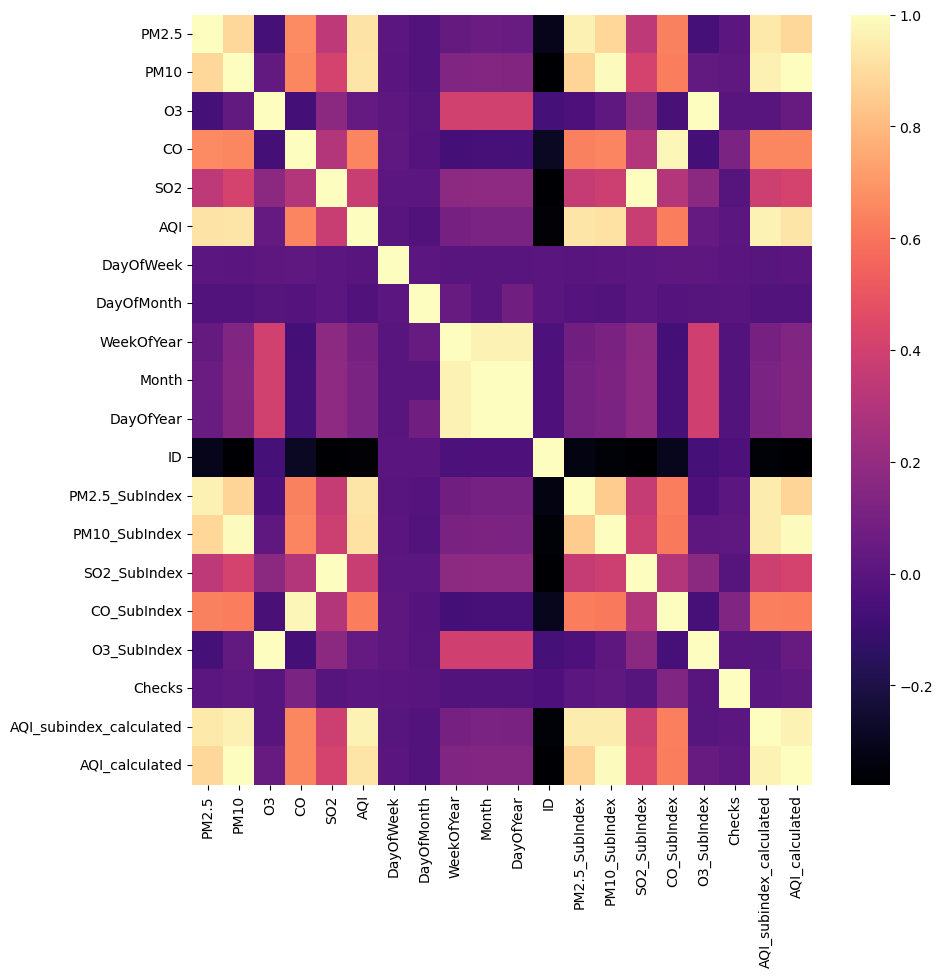

In [99]:
plt.figure(figsize=(10,10))
plt.tight_layout()
sns.heatmap(df.corr(),cmap='magma')

## Correct split and taking only highly correlated columns with AQI

In [103]:
# Using diff_df
diff_df = df[['Date', 'PM2.5', 'PM10', 'CO', 'SO2', 'AQI', 'ID',
       'PM2.5_SubIndex', 'PM10_SubIndex', 'SO2_SubIndex', 'CO_SubIndex', 'AQI_subindex_calculated']]

train = pd.DataFrame(columns = diff_df.columns)  
valid = pd.DataFrame(columns = diff_df.columns)  

for station in diff_df['ID'].unique():
    print('NEW LOCATION -',station)
    location_train_df = diff_df[diff_df["ID"] == station]
    
    index = (80 * len(location_train_df['AQI'].values))//100
    
    t =  location_train_df.iloc[:index]
    v = location_train_df.iloc[index:]
    
    train = train.append(t)
    valid = valid.append(v)    

hf_train = h2o.H2OFrame(train)
hf_valid = h2o.H2OFrame(valid)

# identify predictors and response variable
y = 'AQI'
x = hf_train.columns
x.remove(y)

# initialize AutoML and start training

aml = H2OAutoML(seed=42, sort_metric='MAE', verbosity='info', max_runtime_secs=600, nfolds=0)
aml.train(x=x, y=y, training_frame=hf_train, validation_frame=hf_valid)

NEW LOCATION - 0
NEW LOCATION - 1
NEW LOCATION - 2
NEW LOCATION - 3
NEW LOCATION - 4
NEW LOCATION - 5
NEW LOCATION - 6
NEW LOCATION - 7
NEW LOCATION - 8
NEW LOCATION - 9
NEW LOCATION - 10
NEW LOCATION - 11
NEW LOCATION - 12
NEW LOCATION - 13
NEW LOCATION - 14
NEW LOCATION - 15
NEW LOCATION - 16
NEW LOCATION - 17
NEW LOCATION - 18
NEW LOCATION - 19
NEW LOCATION - 20
NEW LOCATION - 21
NEW LOCATION - 22
NEW LOCATION - 23
NEW LOCATION - 24
NEW LOCATION - 25
NEW LOCATION - 26
NEW LOCATION - 27
NEW LOCATION - 28
NEW LOCATION - 29
NEW LOCATION - 30
NEW LOCATION - 31
NEW LOCATION - 32
NEW LOCATION - 33
NEW LOCATION - 34
NEW LOCATION - 35
NEW LOCATION - 36
NEW LOCATION - 37
NEW LOCATION - 38
NEW LOCATION - 39
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
21:56:01.533: Project: AutoML_13_20230414_215601
21:56:01.533: Cross-validation d

Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_grid_1_AutoML_13_20230414_215601_model_14


Model Summary: 
    number_of_trees
--  -----------------
    65

ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 293.8387576815102
RMSE: 17.141725633130118
MAE: 11.546283392903364
RMSLE: 0.11213489877024306
Mean Residual Deviance: 293.8387576815102

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 830.2487226735512
RMSE: 28.814036903452998
MAE: 20.82634315475728
RMSLE: 0.2052684237703335
Mean Residual Deviance: 830.2487226735512

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance    validation_rmse    validation_mae    validation_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------  -----------------  ----------------  ---------------------
    2023-04-14 21:56:42  18.136 sec  0                  233.269          194.717         54414.2              206.863            170.946           42792.2
    2023-04-14 21:56:42  18.218 sec  5                  55.924           38.8543         3127.5               49.8483            35.8067           2484.85
    2023-04-14 21:56:42  18.372 sec  10                 32.6445          21.2872         1065.67              31.7106            22.0719           1005.56
    2023-04-14 21:56:43  18.566 sec  15                 28.2357          18.5781         797.256              30.2114            21.2259           912.726
    2023-04-14 21:56:43  18.769 sec  20                 26.1332          17.372          682.944              29.6366            20.9612           878.331
    2023-04-14 21:56:43  18.982 sec  25                 24.2458          16.205          587.86               29.3134            20.8544           859.276
    2023-04-14 21:56:43  19.215 sec  30                 22.7792          15.2795         518.892              29.1112            20.7716           847.46
    2023-04-14 21:56:43  19.476 sec  35                 21.8047          14.6553         475.447              29.0876            20.776            846.087
    2023-04-14 21:56:44  19.740 sec  40                 20.8826          14.0728         436.082              28.9991            20.7387           840.945
    2023-04-14 21:56:44  20.027 sec  45                 20.1129          13.5679         404.527              28.9215            20.7293           836.453
    2023-04-14 21:56:44  20.348 sec  50                 19.2444          12.9983         370.348              28.8832            20.7593           834.241
    2023-04-14 21:56:45  20.689 sec  55                 18.4579          12.4553         340.696              28.88              20.7817           834.054
    2023-04-14 21:56:45  21.045 sec  60                 17.721           11.9369         314.033              28.8156            20.7969           830.341
    2023-04-14 21:56:45  21.419 sec  65                 17.1417          11.5463         293.839              28.814             20.8263           830.249

Variable Importances: 
variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ------------
AQI_subindex_calculated  4.95517e+08            1                    0.843369
PM2.5                    5.02854e+07            0.101481             0.0855856
PM10                     1.91862e+07            0.0387196            0.0326549
Date                     1.06456e+07            0.0214838            0.0181188
PM2.5_SubIndex           3.10852e+06            0.00627329           0.0052907
ID                       2.54413e+06            0.00513429           0.0043301
CO                       2.3278e+06             0.00469772           0.00396192
SO2                      2.31543e+06            0.00467275           0.00394085
PM10_SubIndex            756529                 0.00152675